### Q1. Install MLFlow
Once you installed the package, run the command mlflow --version and check the output.

What's the version that you have?

In [2]:
import mlflow

!mlflow --version

mlflow, version 2.13.0


- Answer: 2.13.0

### Q2. Download and preprocess the data
How many files were saved to OUTPUT_FOLDER?

In [4]:
import os

print(len(os.listdir("data-homework"))+1)

4


- Answer: 4

### Q3. Train a model with autolog

What is the value of the min_samples_split parameter:

In [ ]:
# From train.py - run as a separate script
# modified to enable auto logging
import os
import pickle
import click

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-homework")

def load_pickle(filename: str):
    with open(filename, "rb") as f_in:
        return pickle.load(f_in)


@click.command()
@click.option(
    "--data_path",
    default="./output",
    help="Location where the processed NYC taxi trip data was saved"
)
def run_train(data_path: str):

    X_train, y_train = load_pickle(os.path.join(data_path, "train.pkl"))
    X_val, y_val = load_pickle(os.path.join(data_path, "val.pkl"))

    rf = RandomForestRegressor(max_depth=10, random_state=0)
    
    with mlflow.start_run():
        mlflow.autolog()
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)


if __name__ == '__main__':
    run_train()

- Answer: min_samples_split = 2

### Q4. Launch the tracking server locally

Your task is to:

- launch the tracking server on your local machine,
- select a SQLite db for the backend store and a folder called artifacts for the artifacts store.

You should keep the tracking server running to work on the next two exercises that use the server.

In addition to backend-store-uri, what else do you need to pass to properly configure the server?

- Answer: 'default-artifact-root'. 

- Full command: mlflow ui --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./02-experiment-tracking/artifacts

In [3]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment-homework")

2024/06/03 15:26:45 INFO mlflow.tracking.fluent: Experiment with name 'nyc-taxi-experiment-homework' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///c:/Users/BazB1/Desktop/Work/mlops-zoomcamp/02-experiment-tracking/mlruns/4', creation_time=1717424805166, experiment_id='4', last_update_time=1717424805166, lifecycle_stage='active', name='nyc-taxi-experiment-homework', tags={}>

### Q5. Tune model hyperparameters

Now let's try to reduce the validation error by tuning the hyperparameters of the RandomForestRegressor using hyperopt. We have prepared the script hpo.py for this exercise.

Your task is to modify the script hpo.py and make sure that the validation RMSE is logged to the tracking server for each run of the hyperparameter optimization (you will need to add a few lines of code to the objective function) and run the script without passing any parameters.

After that, open UI and explore the runs from the experiment called random-forest-hyperopt to answer the question below.

Note: Don't use autologging for this exercise.

The idea is to just log the information that you need to answer the question below, including:

- the list of hyperparameters that are passed to the objective function during the optimization,
- the RMSE obtained on the validation set (February 2023 data).

What's the best validation RMSE that you got?

In [ ]:
# From hpo.py - run as a separate script
# modified to log params and rmse metric
import os
import pickle
import click
import mlflow
import numpy as np
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from hyperopt.pyll import scope
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("random-forest-hyperopt")


def load_pickle(filename: str):
    with open(filename, "rb") as f_in:
        return pickle.load(f_in)


@click.command()
@click.option(
    "--data_path",
    default="./output",
    help="Location where the processed NYC taxi trip data was saved"
)
@click.option(
    "--num_trials",
    default=15,
    help="The number of parameter evaluations for the optimizer to explore"
)
def run_optimization(data_path: str, num_trials: int):

    X_train, y_train = load_pickle(os.path.join(data_path, "train.pkl"))
    X_val, y_val = load_pickle(os.path.join(data_path, "val.pkl"))

    def objective(params):

        rf = RandomForestRegressor(**params)

        with mlflow.start_run():
            mlflow.log_params(params)
            rf.fit(X_train, y_train)
            y_pred = rf.predict(X_val)
            rmse = mean_squared_error(y_val, y_pred, squared=False)
            mlflow.log_metric("rmse", rmse)

        return {'loss': rmse, 'status': STATUS_OK}

    search_space = {
        'max_depth': scope.int(hp.quniform('max_depth', 1, 20, 1)),
        'n_estimators': scope.int(hp.quniform('n_estimators', 10, 50, 1)),
        'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 10, 1)),
        'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 4, 1)),
        'random_state': 42
    }

    rstate = np.random.default_rng(42)  # for reproducible results
    fmin(
        fn=objective,
        space=search_space,
        algo=tpe.suggest,
        max_evals=num_trials,
        trials=Trials(),
        rstate=rstate
    )


if __name__ == '__main__':
    run_optimization()

- Answer: 5.335
- 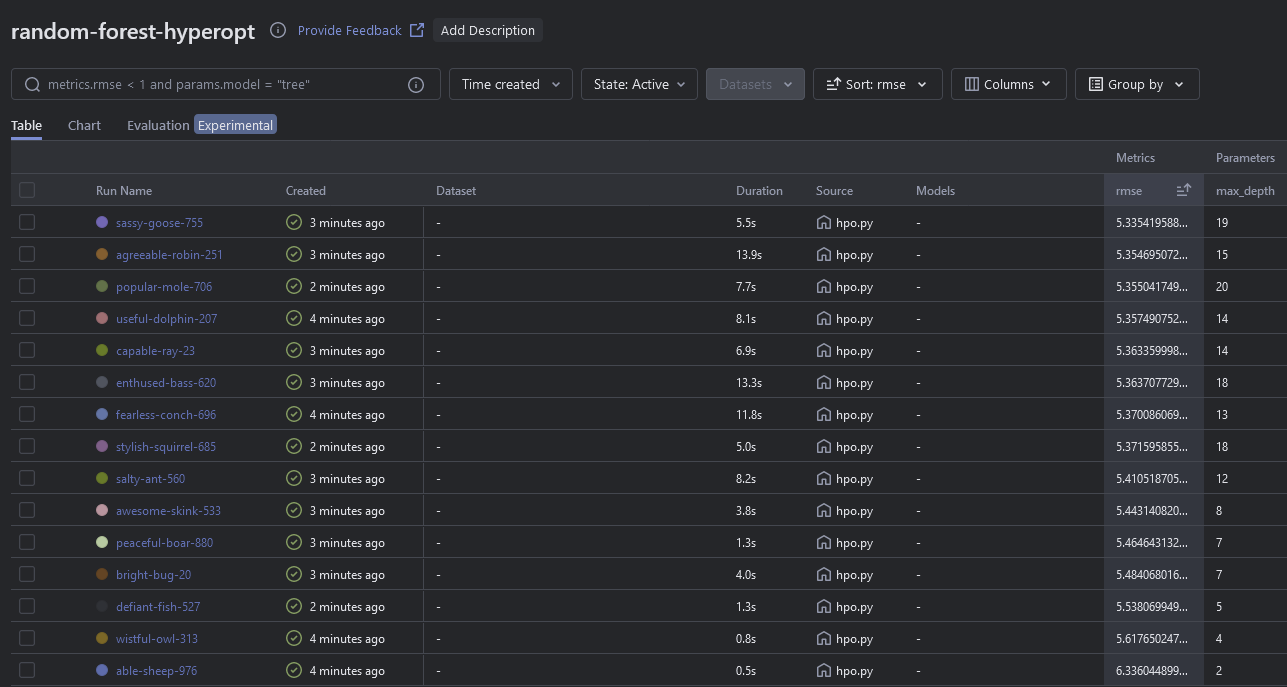

### Q6. Promote the best model to the model registry

The results from the hyperparameter optimization are quite good. So, we can assume that we are ready to test some of these models in production. In this exercise, you'll promote the best model to the model registry. We have prepared a script called register_model.py, which will check the results from the previous step and select the top 5 runs. After that, it will calculate the RMSE of those models on the test set (March 2023 data) and save the results to a new experiment called random-forest-best-models.

Your task is to update the script register_model.py so that it selects the model with the lowest RMSE on the test set and registers it to the model registry.

Tip 1: you can use the method search_runs from the MlflowClient to get the model with the lowest RMSE,

Tip 2: to register the model you can use the method mlflow.register_model and you will need to pass the right model_uri in the form of a string that looks like this: "runs:/<RUN_ID>/model", and the name of the model (make sure to choose a good one!).

What is the test RMSE of the best model?

In [ ]:
# From register_model.py - run as a separate script
# modified to select the best model based on test RMSE
# and register it to the model registry.
import os
import pickle
import click
import mlflow

from mlflow.entities import ViewType
from mlflow.tracking import MlflowClient
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

HPO_EXPERIMENT_NAME = "random-forest-hyperopt"
EXPERIMENT_NAME = "random-forest-best-models"
RF_PARAMS = ['max_depth', 'n_estimators', 'min_samples_split', 'min_samples_leaf', 'random_state']

mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.sklearn.autolog()


def load_pickle(filename):
    with open(filename, "rb") as f_in:
        return pickle.load(f_in)


def train_and_log_model(data_path, params):
    X_train, y_train = load_pickle(os.path.join(data_path, "train.pkl"))
    X_val, y_val = load_pickle(os.path.join(data_path, "val.pkl"))
    X_test, y_test = load_pickle(os.path.join(data_path, "test.pkl"))

    with mlflow.start_run():
        new_params = {}
        for param in RF_PARAMS:
            new_params[param] = int(params[param])

        rf = RandomForestRegressor(**new_params)
        rf.fit(X_train, y_train)

        # Evaluate model on the validation and test sets
        val_rmse = mean_squared_error(y_val, rf.predict(X_val), squared=False)
        mlflow.log_metric("val_rmse", val_rmse)
        test_rmse = mean_squared_error(y_test, rf.predict(X_test), squared=False)
        mlflow.log_metric("test_rmse", test_rmse)


@click.command()
@click.option(
    "--data_path",
    default="./output",
    help="Location where the processed NYC taxi trip data was saved"
)
@click.option(
    "--top_n",
    default=5,
    type=int,
    help="Number of top models that need to be evaluated to decide which one to promote"
)
def run_register_model(data_path: str, top_n: int):

    client = MlflowClient()

    # Retrieve the top_n model runs and log the models
    experiment = client.get_experiment_by_name(HPO_EXPERIMENT_NAME)
    runs = client.search_runs(
        experiment_ids=experiment.experiment_id,
        run_view_type=ViewType.ACTIVE_ONLY,
        max_results=top_n,
        order_by=["metrics.rmse ASC"]
    )
    for run in runs:
        train_and_log_model(data_path=data_path, params=run.data.params)

    # Select the model with the lowest test RMSE
    experiment = client.get_experiment_by_name(EXPERIMENT_NAME)
    best_run = client.search_runs(
        experiment_ids=experiment.experiment_id,
        run_view_type=ViewType.ACTIVE_ONLY,
        max_results=1,
        order_by=["metrics.test_rmse ASC"]
    )[0]

    # Register the best model
    run_id = best_run.info.run_id
    model_uri = f"runs:/{run_id}/model"

    mlflow.register_model(model_uri=model_uri, name="random-forest-best-model")

if __name__ == '__main__':
    run_register_model()


- Answer: 5.567
- 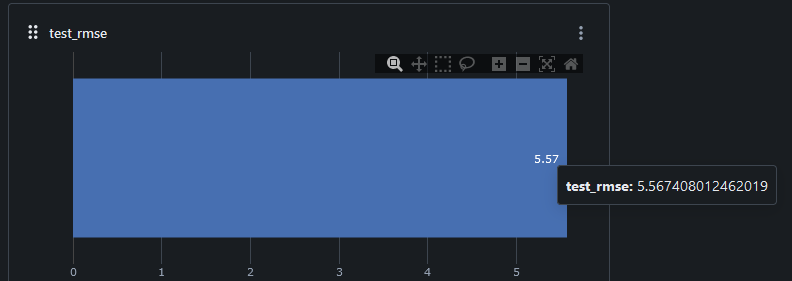